# HMS: MobileNet with 5 folds cross-validation

This is one of the competition notebooks for the competition

https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview

This notebook is based on

https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

but instead of using EfficientNetB0,, I trained MobileNet with 5 fold cross validation on the dataset provided in the competition above. 


In [1]:
import gc
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

VER = 3
#Ver3 uses data augmentation, longer training: 15 epochs with cosine type LR scheduler
#V1 uses step scheduler with 5 epochs, CV 0.75, no data augmentation
#V2 uses cosine scheduler with 10 epochs, CV 0.622, no data augmentation

2024-03-02 08:40:24.303579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 08:40:24.303699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 08:40:24.453098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version = 2.15.0
Using 2 GPUs


# Load original data

In [2]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [3]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )


Train non-overlapp eeg_id shape: (17089, 12)


In [4]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Reading Spectrograms and EEGs

In [5]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 2.67 s, sys: 6.01 s, total: 8.68 s
Wall time: 56.1 s


In [6]:
print(f'There are {len(spectrograms.items())} items in the dictionary spectrograms')
print(f'The first key in this dictionary is {list(spectrograms.keys())[0]}')
print(f'The first value corresponding to the first key above has the shape {list(spectrograms.values())[0].shape}')

There are 11138 items in the dictionary spectrograms
The first key in this dictionary is 319287046
The first value corresponding to the first key above has the shape (752, 400)


In [7]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 4.14 s, sys: 8.25 s, total: 12.4 s
Wall time: 1min 10s


In [8]:
print(f'There are {len(all_eegs.items())} items in the dictionary all_eegs')
print(f'The first key in this dictionary is {list(all_eegs.keys())[0]}')
print(f'The first value corresponding to the first key above has the shape {list(all_eegs.values())[0].shape}')

There are 17089 items in the dictionary all_eegs
The first key in this dictionary is 1628180742
The first value corresponding to the first key above has the shape (128, 256, 4)


# Data Loader

In [9]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms, eeg_specs = all_eegs): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X) 
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        
        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        img = np.ones((128,256),dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test': 
                r = 0
            else: 
                r = int( (row['min'] + row['max'])//4 )

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img,np.exp(-4),np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img-m)/(s+ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j,14:-14,:,k] = img[:,22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j,:,:,4:] = img
                
            if self.mode!='test':
                y[j,] = row[TARGETS]
            
        return X,y
    
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

# Display loaded data

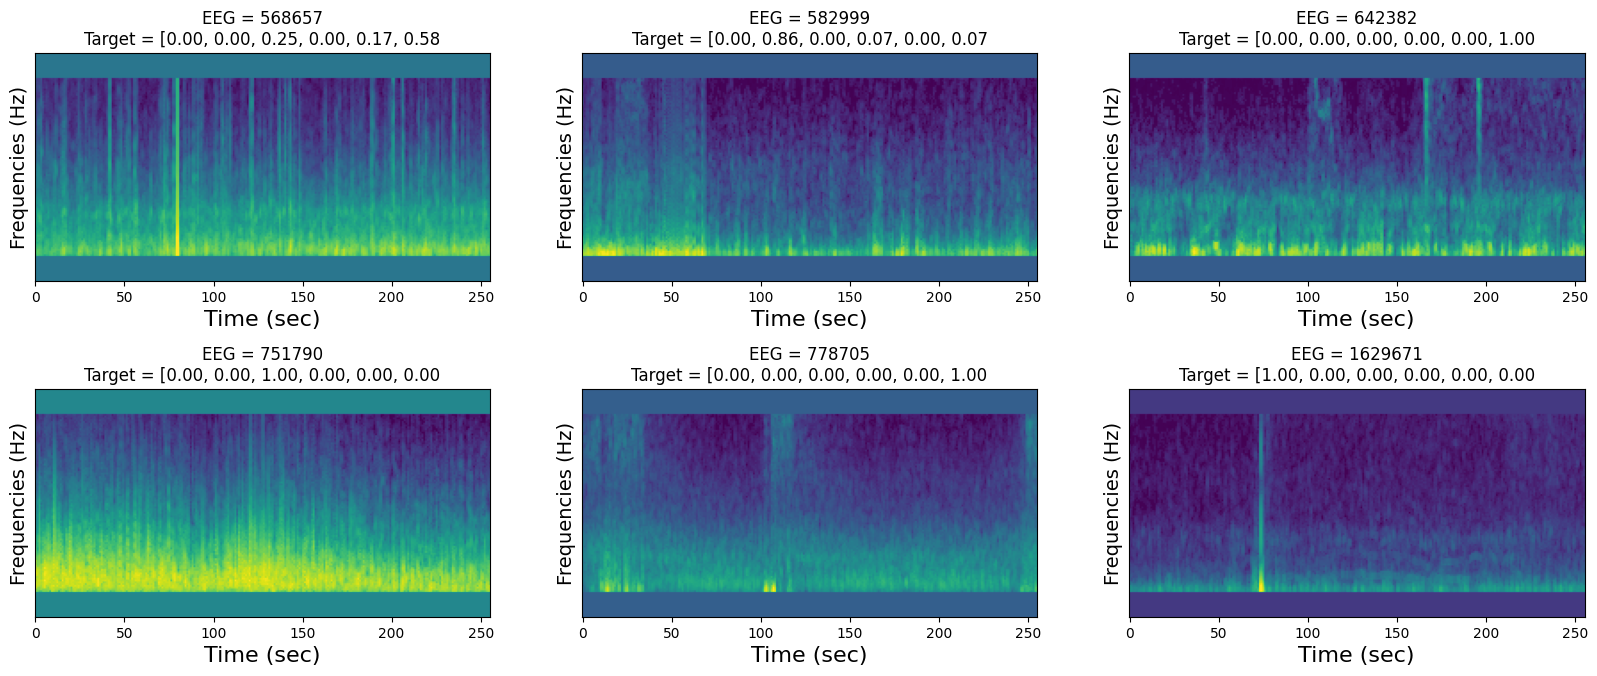

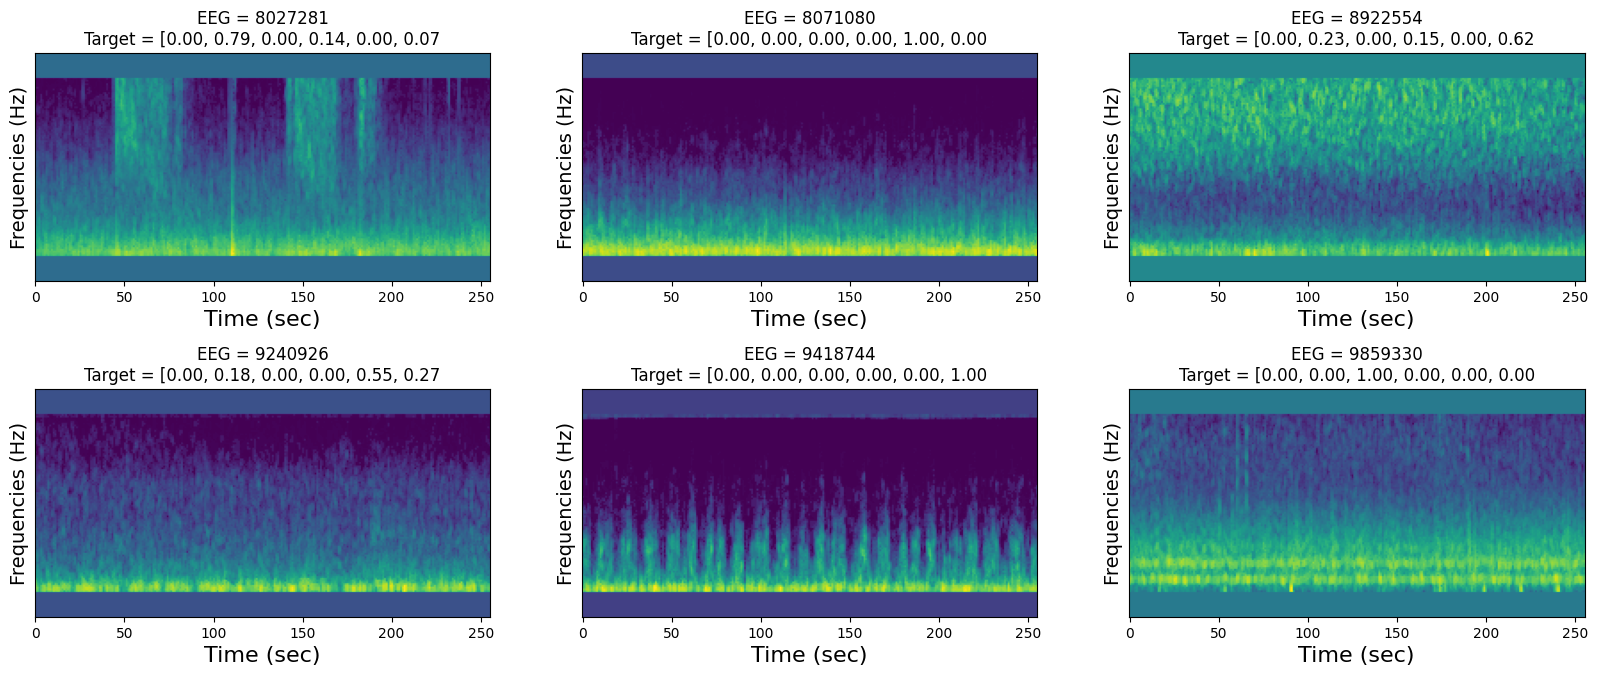

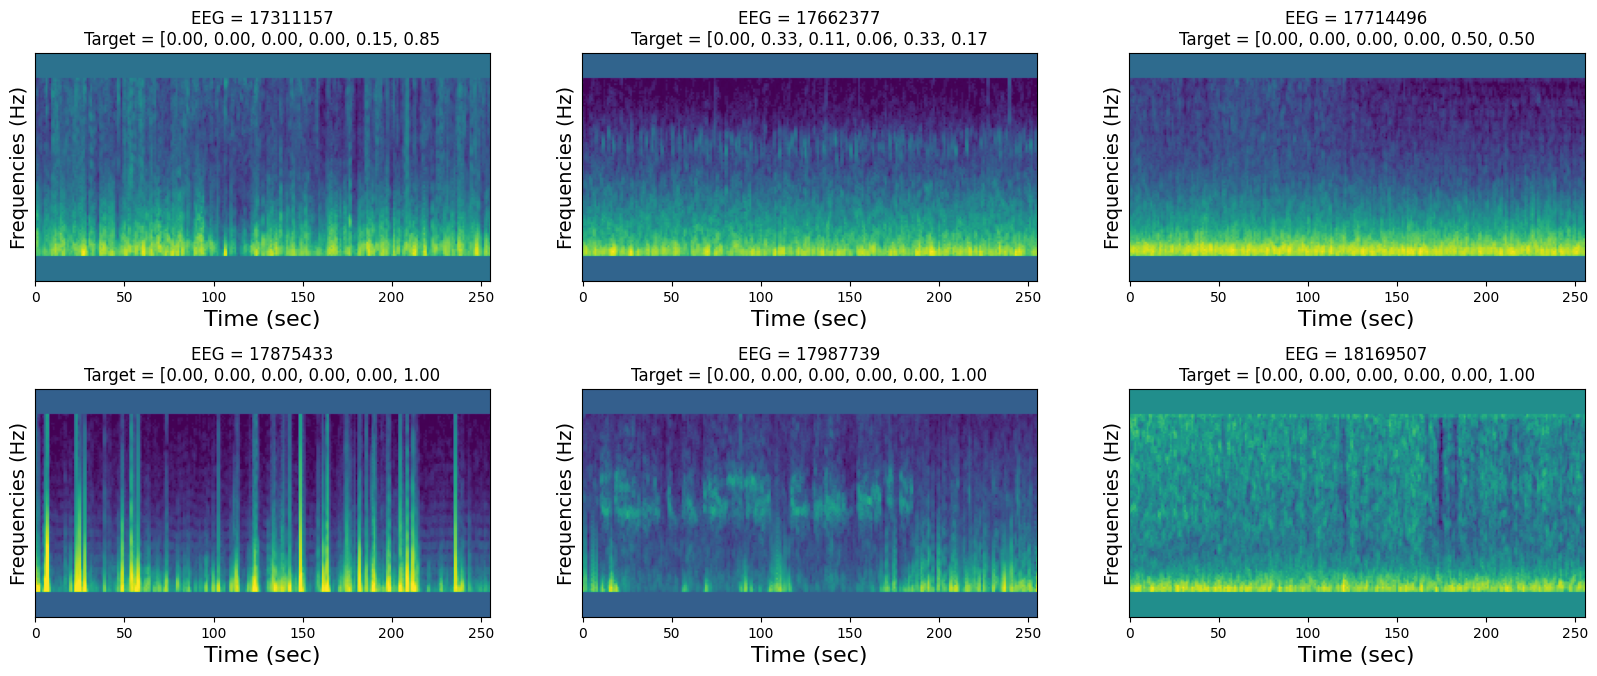

In [10]:
gen = DataGenerator(train, batch_size=32, shuffle=False)
ROWS=2; COLS=3; BATCHES=3

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0][::-1,]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]: tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break

# Learning rate scheduler

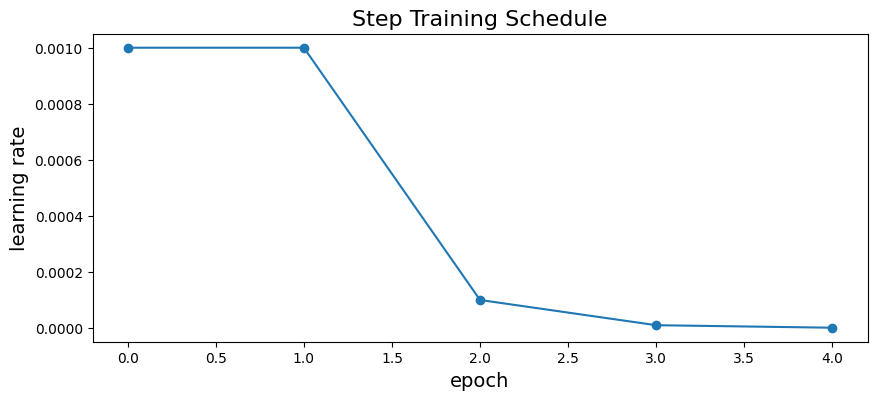

In [11]:
#STEP TYPE
LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//EVERY)
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-'); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Step Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

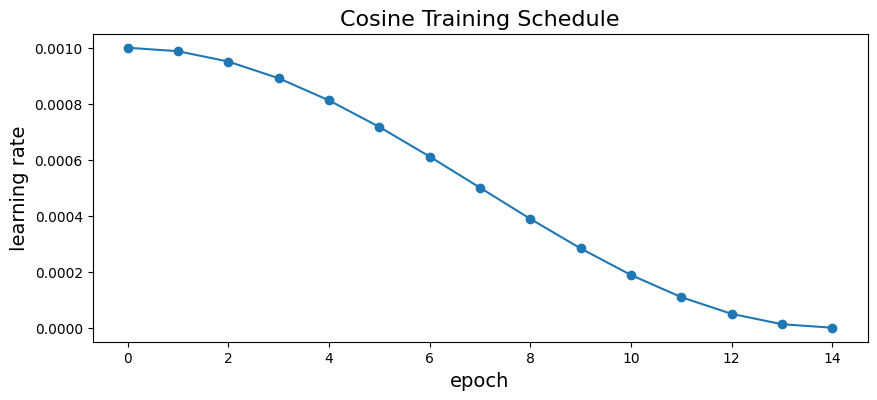

In [12]:
#COSINE TYPE
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 15

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Build MobileNet

In [13]:
from tensorflow.keras.applications import MobileNetV2

In [14]:
#use both Kaggle and eeg spectrograms
USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

In [15]:
def build_model(pretrained_model):
    
    inp = tf.keras.Input(shape=(128,256,8))
    base_model = pretrained_model(include_top=False, weights = 'imagenet', input_shape=None)
   
    # RESHAPE INPUT 128x256x8 => 512x512x3 MONOTONE IMAGE
    # KAGGLE SPECTROGRAMS
    x1 = [inp[:,:,:,i:i+1] for i in range(4)]
    x1 = tf.keras.layers.Concatenate(axis=1)(x1)
    # EEG SPECTROGRAMS
    x2 = [inp[:,:,:,i+4:i+5] for i in range(4)]
    x2 = tf.keras.layers.Concatenate(axis=1)(x2)
    # MAKE 512X512X3
    if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
        x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
    elif USE_EEG_SPECTROGRAMS: x = x2
    else: x = x1
    x = tf.keras.layers.Concatenate(axis=3)([x,x,x])
    
    # OUTPUT
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
        
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt) 
        
    return model

In [16]:
#Cross-validation part
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

#USING STEP TYPE TRAINING
LOAD_MODELS_FROM = None

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
    print('#'*25)
    print(f'### Fold {i+1}')
    #Version 3 of the notebook: Use data augmentation
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32, augment=True)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model(MobileNetV2)
    if LOAD_MODELS_FROM is None:
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
            #use cosine type scheduler
              epochs=EPOCHS, callbacks = [LR2])
        model.save_weights(f'MobileNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}MobileNet_v{VER}_f{i}.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
9406464/9406464 [==============================] - 0s 0us/step

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/15


I0000 00:00:1709369022.105722      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 [==============================] - 262s 481ms/step - loss: 0.7444 - val_loss: 7.4664 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000987476492134821.
Epoch 2/15
428/428 [==============================] - 198s 462ms/step - loss: 0.6044 - val_loss: 6.8491 - lr: 9.8748e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009505339495172585.
Epoch 3/15
428/428 [==============================] - 197s 461ms/step - loss: 0.5484 - val_loss: 1.7888 - lr: 9.5053e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000891024825492781.
Epoch 4/15
428/428 [==============================] - 198s 463ms/step - loss: 0.5141 - val_loss: 2.9565 - lr: 8.9102e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0008119331560284375.
Epoch 5/15
428/428 [==============================] - 199s 464ms/step - loss: 0.4793 - val_loss: 1.4318 - lr: 8.1193e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0007172249276892204.
Epoch 6/15
4

In [17]:
# Evaluation

import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for MobileNetV2 =',cv)


CV Score KL-Div for MobileNetV2 = 0.7181998711048235


# Load test data and convert EEGs to spectrograms

In [18]:
del all_eegs, spectrograms; gc.collect()

0

In [19]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [20]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

There are 1 test spectrogram parquets
0 , 

In [21]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



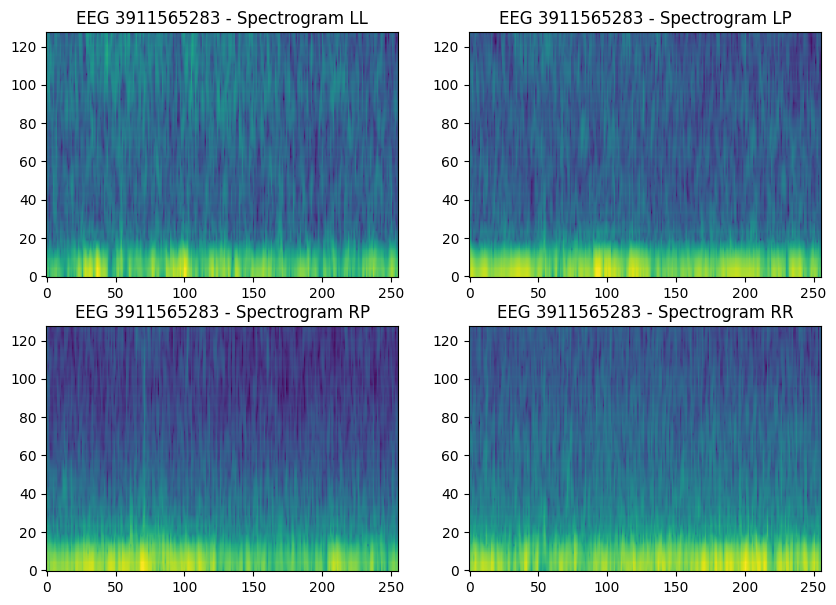

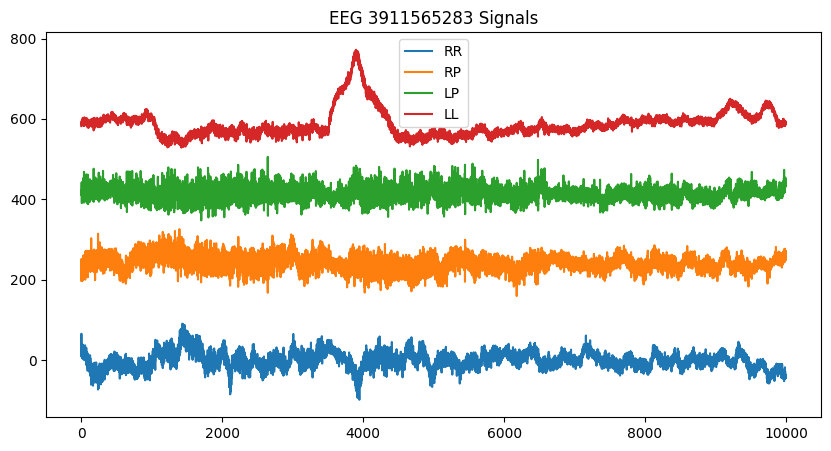


#########################



In [22]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = img

# Infer MobileNet on test data

In [23]:
preds = []
model = build_model(MobileNetV2)
test_gen = DataGenerator(test, shuffle=False, batch_size=64, mode='test',
                         specs = spectrograms2, eeg_specs = all_eegs2)

for i in range(5):
    print(f'Fold {i+1}')
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}MobileNet_v{VER}_f{i}.h5')
    else:
        model.load_weights(f'MobileNet_v{VER}_f{i}.h5')
    pred = model.predict(test_gen, verbose=1)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Fold 1
1/1 [==============================] - 2s 2s/step
Fold 2
1/1 [==============================] - 0s 41ms/step
Fold 3
1/1 [==============================] - 0s 39ms/step
Fold 4
1/1 [==============================] - 0s 42ms/step
Fold 5
1/1 [==============================] - 0s 40ms/step

Test preds shape (1, 6)


In [24]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.375836,0.090716,0.000189,0.260475,0.00886,0.263923


In [25]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32